# Assignment 3 - Stochastic Processes

    Name: Clara Periago
    Student #: s1067476

In [5]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.experimental import io_callback
from pathlib import Path
import shutil
import glob

In [128]:
# these are copy pasted from the last exercise
def rk4(f, dt):
    @jax.jit
    def step(x, t):
        k1 = f(t, x)
        k2 = f(t + .5 * dt, x + .5 * dt * k1)
        k3 = f(t + .5 * dt, x + .5 * dt * k2)
        k4 = f(t + dt, x + dt * k3)

        xn1 = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        return xn1

    return step

# helper wrapper that takes a step solver, initial conditions and time domain
def simulate(solver, c0, t):
    def iterate(c, t):
        xn1 = solver(c, t)
        # return xn1, xn1
        io_callback(save_frame_to_host, None, xn1, t)
        return xn1, None
    
    _, xs = jax.lax.scan(iterate, c0, t)
    return xs

def save_frame_to_host(x, t):
    jnp.save(f"./chunk_{int(t*1000)}.npy", x)

def read_dir(path, yield_every=100):
    files = sorted(glob.glob(path))
    for file in files:
        arr = jnp.load(file)
        for i in range(0, len(arr), yield_every):
            yield arr[i]


def simulate_chunked(solver, c0, t, chunk=1000):
    out_dir = Path("./out")
    shutil.rmtree(out_dir, ignore_errors=True)
    out_dir.mkdir(parents=True)

    def single_chunk(x0, i):
        ti = t[i:i+chunk]
        def step(carry, t_):
            x = solver(carry, t_)
            x = jnp.clip(x, 0, 1)
            # x = (x * 255).astype(jnp.uint8)
            return x, x   # keep local chunk only
        return jax.lax.scan(step, x0, ti)

    x = c0
    for i in range(0, len(t), chunk):
        x, chunk_data = single_chunk(x, i)
        jnp.save(out_dir / f"chunk_{i}.npy", chunk_data)  # store to disk
        del chunk_data
    return x

In [129]:
lapl = jnp.array(
    [[0.05, 0.2, 0.05],
     [0.2, -1.0, 0.2],
     [0.05, 0.2, 0.05]]
)

def draw_fn(ax, grid):
    A, B = grid
    ax.imshow((B / (A + B)).T, cmap='Spectral')

def diffuse(k_i, dk):
    return dk * jax.scipy.signal.convolve2d(k_i, lapl, mode="same", boundary="fill", fillvalue=0)

def bunny_dynamics(dK, dt, feed, kill, reproduction):
    def f(t, c):
        K = c  # (k, w, h)
        G, B = K # Grass, Bunny
        # G, B = jnp.clip(K, 0, 1) # Grass, Bunny

        bunnies_reproduced = reproduction * G * B**2

        next_K = jnp.array([
            feed * (1 - G) - bunnies_reproduced,
            - kill * G + bunnies_reproduced,
        ])

        k_diffused = jax.vmap(diffuse, in_axes=(0, 0))(K, dK)

        next_K = k_diffused + next_K
        
        return next_K
    
    def gup(x, t):
        return f(t, x)
 
    solver = rk4(f, dt)
    # solver = gup

    return solver

In [130]:
dt = 1.
t = jnp.arange(0, 5_000, dt)
nK = 2
dK = jnp.array([.5, .25])
w, h = 480, 480

grid = jnp.stack(
    [
        jnp.ones(shape=(w, h)),#, dtype=jnp.uint8),
        jnp.zeros(shape=(w, h))#, dtype=jnp.uint8)
    ]
)

seed_size = 11
grid = grid.at[
    1,
    int(w / 2) - int(seed_size / 2) : int(w / 2) + int(seed_size / 2) + 1,
    int(h / 2) - int(seed_size / 2) : int(h / 2) + int(seed_size / 2) + 1,
].set(jnp.ones((seed_size, seed_size)))#, dtype=jnp.uint8) * 255)

solver = bunny_dynamics(dK, dt, 0.3, 0.4, 1)
s0 = grid  # initial state
xyzs = simulate_chunked(solver, s0, t, chunk=10_000)  # iterate over the t space
xyzs.shape

(2, 480, 480)

In [136]:
xyz_history = jnp.stack(list(read_dir("./out/chunk_*.npy", yield_every=1)))
xyz_history.shape

(5000, 2, 480, 480)

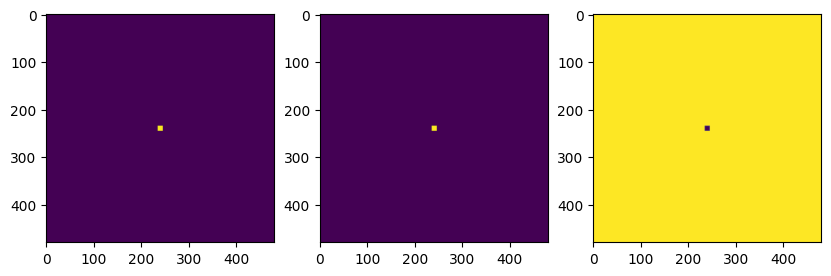

In [141]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

A0, B0 = xyz_history[0]
A1, B1 = xyz_history[-1]

ax1.imshow(B0 / (A0 + B0))
ax2.imshow(B1 / (A1 + B1))
ax3.imshow(B0 / (A0 + B0) - B1 / (A1 + B1))

In [137]:
xyz_history[-1] - xyz_history[0]

Array([[[-0.22119439, -0.19312203, -0.17761135, ..., -0.17761135,
         -0.19312203, -0.22119439],
        [-0.19312203, -0.1464904 , -0.122953  , ..., -0.12295294,
         -0.14649034, -0.19312203],
        [-0.17761135, -0.12295306, -0.09634686, ..., -0.09634686,
         -0.12295306, -0.17761135],
        ...,
        [-0.17761135, -0.122953  , -0.09634686, ..., -0.09634686,
         -0.12295306, -0.17761135],
        [-0.19312203, -0.1464904 , -0.122953  , ..., -0.122953  ,
         -0.1464904 , -0.19312203],
        [-0.22119439, -0.19312203, -0.17761135, ..., -0.17761135,
         -0.19312203, -0.22119439]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [132]:
xyz_history.nbytes

9216000000

In [111]:
xyzs.nbytes * len(t)

185088800

In [133]:
from typing import Sequence
from IPython.display import HTML, Video
import io
import base64
import imageio.v3 as iio


def mp4_inline(frames, fps=20):
    print(frames.shape)
    buffer = io.BytesIO()
    frames = frames.transpose(0, 2, 1, 3)
    iio.imwrite(buffer, frames, extension=".mp4", fps=fps, codec="h264")
    b64 = base64.b64encode(buffer.getvalue()).decode()

    return Video(url=f"data:video/mp4;base64,{b64}", width=1024, height=768,)
    return HTML(f"""
        <video controls autoplay loop>
            <source src="data:video/mp4;base64,{b64}" type="video/mp4">
        </video>
    """)
    
def resample01(arr):
    mx = arr.max()
    mn = arr.min()
    return (arr - mn) / (mx - mn)

def animate_draw(frames: Sequence, fps=20):
    cmap = plt.get_cmap("Spectral")

    frame_out = []

    for i, x in enumerate(frames):
        A, B = x
        frame = B / (A + B)
        frame = resample01(frame)
        rgb = (cmap(frame)[..., :3] * 255).astype(jnp.uint8)
        frame_out.append(rgb)
        # img = ax.imshow((B / (A + B)).T, cmap='Spectral', animated=True)
        # frame_out.append([img])

    return mp4_inline(jnp.stack(frame_out), fps=fps)


float32 1843200


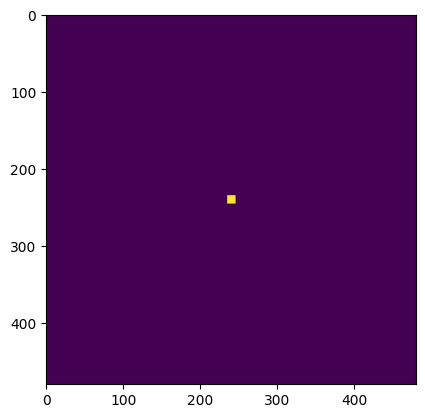

In [134]:
A, B = xyzs
frame = B / (A + B)
print(xyzs.dtype, xyzs.nbytes)
plt.imshow(resample01(frame))

In [135]:
fps = 24

arr_generator = read_dir("./out/chunk_*.npy", yield_every=int(1/dt))# yield_every=1)#
anim = animate_draw(arr_generator, fps=fps)
anim

(5000, 480, 480, 3)


/Users/clara/.local/share/uv/python/cpython-3.12.11-macos-aarch64-none/lib/python3.12/subprocess.py:1885: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
